# Multi Agent Shopping Mall System 

- Author: [Heeah Kim](https://github.com/yellowGangneng)
- Peer Review: [Jongcheol Kim](https://github.com/greencode-99), [HeeWung Song](https://github.com/kofsitho87)
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/16-MultiAgentShoppingMallSystem.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/16-MultiAgentShoppingMallSystem.ipynb)

## Overview

Hello, everyone!  
In this tutorial, we will build a shopping mall system using **Multi Agent**!  
By the end of this tutorial, you will become the owner of a very impressive shopping mall!  
An impressive owner with several solid **agents** as employees!  

Our shopping mall will be structured with one manager who oversees the purchasing and sales systems,  
a purchasing specialist dedicated to the purchasing system,  
and a sales specialist dedicated to the sales system.

Each role will perform the following tasks:

**Manager**
- Validate Login: Determines whether the user is a legitimate user of our service.
- Assign Tasks: Assigns appropriate tasks to specialists based on user requirements.

**Purchase Specialist**
- Recommend Items: Suggests suitable items based on user needs.
- Purchase Items: Buys the items confirmed through recommendations.
- Cancel Purchase: Cancels the purchase if the item has not been dispatched. If it is in transit, unfortunately, we will need to follow exchange/refund procedures (not covered in this tutorial due to its extensive nature).
- Check Item Status: Shows the status of items purchased by the user. There are four possible statuses: Pre-dispatch, In transit, Delivered, and Cancelled.

**Sales Specialist**
- Check Sales History: For sellers, knowing how many items they have sold is crucial. They check their sales history.
- Restock Inventory: Popular items often sell out quickly. This function allows for restocking.
- Update Item Status: When a buyer places an order, we need to dispatch the item. Once safely delivered to the buyer, the shipment status should be updated. This function is for updating the item status.

Once these three roles are implemented, we will have the following type of service.  
<center><img src='./assets/16-multi-agent-shopping-mall-system-01.png' alt='service graph' style="width:50%; height:50%"></center>
      <center style="color:gray">Our Fabulous Service!</center>

Then, let's embark on building our shopping mall service!

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Data preparation](#data-preparation)
- [Define State](#define-state)
- [Define Tools](#define-tools)
- [Define Nodes](#define-nodes)
- [Build the Graph](#build-the-graph)
- [Let's run our service](#let's-run-our-service)

### References

- [Kaggle Hub](https://github.com/Kaggle/kagglehub)
- [dbdiagram.io](https://dbdiagram.io/d)
- [Multi-agent supervisor](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/)
- [Customer Support Langgraph Tutorials](https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/customer-support/customer-support.ipynb)
----

## Environment Setup

Setting up your environment is the first step. See the [Environment Setup](https://wikidocs.net/257836) guide for more details.


**[Note]**

The langchain-opentutorial is a package of easy-to-use environment setup guidance, useful functions and utilities for tutorials.
Check out the  [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [ ]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain",
        "langchain_core",
        "langchain-anthropic",
        "langchain_community",
        "langchain_text_splitters",
        "langchain_openai",
        "kaggle",
        "psycopg2-binary"
    ],
    verbose=False,
    upgrade=False,
)

You can set API keys in a `.env` file or set them manually.

[Note] If you’re not using the `.env` file, no worries! Just enter the keys directly in the cell below, and you’re good to go.

In [3]:
from dotenv import load_dotenv
from langchain_opentutorial import set_env

# Attempt to load environment variables from a .env file; if unsuccessful, set them manually.
if not load_dotenv():
    set_env(
        {
            "OPENAI_API_KEY": "",
            "LANGCHAIN_API_KEY": "",
            "LANGCHAIN_TRACING_V2": "true",
            "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
            "LANGCHAIN_PROJECT": "MultiAgentShoppingMallSystem",  # set the project name same as the title
        }
    )

## Data Preparation

Let's prepare our shopping mall data.  
First, we will use the `fashion-clothing-products-catalog` available on Kaggle.   
This dataset contains the following information:

- productId
- productName
- productBrand
- Gender
- Price
- Description
- Primary Color

There are two ways to obtain the data.

1. Download the data directly from the site.
   The platform we will be using to download the data is *Kaggle*, which hosts a variety of datasets for data analysis competitions.
   Among these, the dataset we will use can be found at the URL below:
   [Fashion Clothing Products Dataset](https://www.kaggle.com/datasets/shivamb/fashion-clothing-products-catalog/data)
   There is a detailed description of the dataset on the site, along with various insightful materials. Please refer to them for more information!

2. Using code. *Kaggle* provides a api, which allows us to download datasets available on Kaggle very easily.

We will use the second method.

To download the dataset, first log in to [Kaggle](https://www.kaggle.com/),  
then click on your profile picture in the top right corner and select 'Settings' from the menu that appears.
<center><img src='./assets/16-multi-agent-shopping-mall-system-02.png' alt='service graph' style="width:50%; height:50%"></center>
      <center style="color:gray">Kaggle Menu</center>
      
Below 'Settings,' there is an 'API' section where you need to click **Create New Token**.

<center><img src='./assets/16-multi-agent-shopping-mall-system-03.png' alt='service graph' style="width:50%; height:50%"></center>
      <center style="color:gray">Kaggle Settings</center>
      
Then, a file named **kaggle.json** will be created.  
Using this json file, you can authenticate the API and utilize the Kaggle API.  

Once you move the file to the .kaggle folder, you will be ready to use the API. The path is as follows.
- mac : ~/.kaggle
- windows : C:/User/{username}/.kaggle

[Note] : [How to Use Kaggle](https://www.kaggle.com/docs/api?utm_me...)

In [4]:
from kaggle.api.kaggle_api_extended import KaggleApi
from glob import glob
import pandas as pd
import numpy as np

api = KaggleApi()
api.authenticate()

api.dataset_download_files('shivamb/fashion-clothing-products-catalog', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/shivamb/fashion-clothing-products-catalog


In [5]:
data = glob('./*.csv')
data

['./myntra_products_catalog.csv']

In [6]:
df = pd.read_csv(data[0])

# Since the `np.int64` type causes errors when loading data into PostgreSQL, convert it to `str` 
# (the database will handle type conversion automatically during insertion).
df = df.map(lambda x: str(x))

df.head()

df.loc[0,'ProductID']

'10017413'

In [7]:
# Let's use exactly 100 pieces of data for convenience, as the dataset is quite large.
df = df.iloc[:100]

In [8]:
### Since our service will not display images, let's remove unnecessary columns.
df = df.drop(columns=['NumImages'])

The data is ready, so we need a database to store it.  
We will use `PostgreSQL`.  
Refer to the code below to set up a `PostgreSQL` database using a Docker container.

However, instead of just `PostgreSQL`, we plan to use an image of `pgvector`,  
which allows for **vector data types** in `PostgreSQL`.

```yaml
services:
  postgres:
    image: ankane/pgvector
    restart: always
    volumes:
      - ./postgres-data:/var/lib/postgresql/data
    ports:
      - "5432:5432"
    environment:
      POSTGRES_USER: postgres
      POSTGRES_PASSWORD: postgres
      POSTGRES_DB: postgres
```

Now that the database is up and running, let's insert our prepared data into the DB!

In [ ]:
import psycopg2

### Connect to the PostgreSQL database.
conn = psycopg2.connect(host='localhost', dbname='postgres', user='postgres', password='postgres', port=5432)
cursor=conn.cursor()

In [ ]:
query = "CREATE EXTENSION vector;"

try:
    cursor.execute(query)
    conn.commit()
    print("Init Setting Complete.")
except Exception as e:
    conn.rollback()
    print(f"An error occurred: {e}")

The database preparation is now complete!  
So, how should we insert the data into the database for our service?  
In our tutorial, we plan to implement only very simple features, so we have also designed the ERD in a simple way, as shown below.

<center><img src='./assets/16-multi-agent-shopping-mall-system-04.png' alt='ERD'></center>
      <center style="color:gray">Our shopping mall service ERD</center>

Noteworthy in the data configuration is `description_ebd` of `inventory`.  
This is the reason why we use `pgvector`. This data is used when recommending items.  
When a user inputs what kind of item they want,  it compares the features of the item described by the user   
with `description_ebd` using **COSINE distance** and recommends the item with the highest similarity.

In short, a Semantic Search is conducted.

[NOTE] [pgvector github](https://github.com/pgvector/pgvector)

In [19]:
queries = []

### Make CREATE TABLE Queries
queries.append(
    """
    CREATE TABLE Product (
      "id" int8 PRIMARY KEY,
      "name" varchar,
      "brand" varchar,
      "gender" varchar,
      "price" integer,
      "description" text,
      "primary_color" varchar
    );
    """
)
queries.append(
    """
    CREATE TABLE ServiceUser (
      "id" varchar PRIMARY KEY,
      "name" varchar,
      "gender" varchar,
      "type" varchar
      );
    """
)
queries.append(
    """
    CREATE TABLE Inventory (
      "id" int8 GENERATED ALWAYS AS IDENTITY PRIMARY KEY,
      "user_id" varchar,
      "product_id" int8,
      "remains" integer,
      "price" integer,
      "description" text,
      description_ebd vector(1536));
    """
)
queries.append(
    """
    CREATE TABLE Purchase (
      "customer_id" varchar,
      "inventory_id" integer,
      "status" varchar);
    """
)

### Make Foreign Key Relationship.
queries.append('ALTER TABLE Inventory ADD FOREIGN KEY ("user_id") REFERENCES ServiceUser ("id");')
queries.append('ALTER TABLE Inventory ADD FOREIGN KEY ("product_id") REFERENCES Product ("id");')
queries.append('ALTER TABLE Purchase ADD FOREIGN KEY ("customer_id") REFERENCES ServiceUser ("id");')
queries.append('ALTER TABLE Purchase ADD FOREIGN KEY ("inventory_id") REFERENCES Inventory ("id");')

try:
    for query in queries:
        cursor.execute(query)
        conn.commit()
    print("Table creation complete.")
except Exception as e:
    conn.rollback()
    print(f"An error occurred: {e}")

Table creation is complete.


In [20]:
### Insert Data
from psycopg2.extras import execute_values

insert_list = [tuple(df.iloc[i]) for i in range(len(df))]

query = f"INSERT INTO Product VALUES %s;"

try:
    execute_values(cursor, query, insert_list)
    conn.commit()
    print("Data insertion completed.")
except Exception as e:
    conn.rollback()
    print(f"An error occurred: {e}")

Data insert is complete.


Let's load dummy data for buyers and sellers.

Creating fictional characters one by one could be one way, but...  
Since we have a reliable tool called GPT, let's actively utilize it!

Let's create 10 dummy data entries each for buyers and sellers.

In [24]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

import os

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.7,
    api_key=os.environ["OPENAI_API_KEY"],
)

prompt = ChatPromptTemplate.from_template(
   """
    You are an expert in generating PostgreSQL queries. Please review the given table information and column details, 
    and write appropriate queries based on the user's questions.
    
    Do not wrap in MD code blocks, do not insert newline characters with \n, just return the SQL query statement only.

    {db_info}
    
    {user_input}
    """
)

chain = prompt | llm

In [33]:
insert_user_queries = chain.invoke({
    "db_info":"""
    # Table information 
    - ServiceUser: A table that contains user information. 
    # Column information 
    - id (varchar): The user's site ID. 
    - name (varchar): The user's name. 
    - gender (varchar): The user's gender. 
    - type (varchar): The user's type. Please just insert TYPE.
    """
    ,"user_input":"""
    # User's Question
    Please return 20 individual insert queries generating dummy data.    
    Please separate each query with \n.
    """}).content

insert_user_queries

"INSERT INTO ServiceUser (id, pw, name, gender, type) VALUES ('user1', 'pass1', 'John Doe', 'Male', 'TYPE'); \nINSERT INTO ServiceUser (id, pw, name, gender, type) VALUES ('user2', 'pass2', 'Jane Smith', 'Female', 'TYPE'); \nINSERT INTO ServiceUser (id, pw, name, gender, type) VALUES ('user3', 'pass3', 'Alice Johnson', 'Female', 'TYPE'); \nINSERT INTO ServiceUser (id, pw, name, gender, type) VALUES ('user4', 'pass4', 'Bob Brown', 'Male', 'TYPE'); \nINSERT INTO ServiceUser (id, pw, name, gender, type) VALUES ('user5', 'pass5', 'Charlie Davis', 'Male', 'TYPE'); \nINSERT INTO ServiceUser (id, pw, name, gender, type) VALUES ('user6', 'pass6', 'Daisy Evans', 'Female', 'TYPE'); \nINSERT INTO ServiceUser (id, pw, name, gender, type) VALUES ('user7', 'pass7', 'Eva Green', 'Female', 'TYPE'); \nINSERT INTO ServiceUser (id, pw, name, gender, type) VALUES ('user8', 'pass8', 'Frank Harris', 'Male', 'TYPE'); \nINSERT INTO ServiceUser (id, pw, name, gender, type) VALUES ('user9', 'pass9', 'Grace Lee'

In [34]:
insert_user_queries = insert_user_queries.split("\n")

insert_user_queries

["INSERT INTO ServiceUser (id, pw, name, gender, type) VALUES ('user1', 'pass1', 'John Doe', 'Male', 'TYPE'); ",
 "INSERT INTO ServiceUser (id, pw, name, gender, type) VALUES ('user2', 'pass2', 'Jane Smith', 'Female', 'TYPE'); ",
 "INSERT INTO ServiceUser (id, pw, name, gender, type) VALUES ('user3', 'pass3', 'Alice Johnson', 'Female', 'TYPE'); ",
 "INSERT INTO ServiceUser (id, pw, name, gender, type) VALUES ('user4', 'pass4', 'Bob Brown', 'Male', 'TYPE'); ",
 "INSERT INTO ServiceUser (id, pw, name, gender, type) VALUES ('user5', 'pass5', 'Charlie Davis', 'Male', 'TYPE'); ",
 "INSERT INTO ServiceUser (id, pw, name, gender, type) VALUES ('user6', 'pass6', 'Daisy Evans', 'Female', 'TYPE'); ",
 "INSERT INTO ServiceUser (id, pw, name, gender, type) VALUES ('user7', 'pass7', 'Eva Green', 'Female', 'TYPE'); ",
 "INSERT INTO ServiceUser (id, pw, name, gender, type) VALUES ('user8', 'pass8', 'Frank Harris', 'Male', 'TYPE'); ",
 "INSERT INTO ServiceUser (id, pw, name, gender, type) VALUES ('use

In [35]:
count = 0

try:
    for insert_user_query in insert_user_queries:
        if count<10:
            count += 1
            insert_user_query = insert_user_query.replace('TYPE', 'customer')
        else:
            insert_user_query = insert_user_query.replace('TYPE', 'vendor')
        cursor.execute(insert_user_query)
        conn.commit()
    print("ServiceUser data insertion completed.")
except Exception as e:
    conn.rollback()
    print(f"An error occurred: {e}")

ServiceUser data insert is complete.


This concludes the preparation of buyer and seller data!

Next, let's load information about the items that the seller will sell into a table called `inventory`!

In [37]:
query = "SELECT * FROM ServiceUser Where type='vendor';"

try:
    cursor.execute(query)
    conn.commit()
    vendors= cursor.fetchall()
    print("Vendor Data selection completed.")
except Exception as e:
    conn.rollback()
    print(f"An error occurred: {e}")

print("vendor data : ",vendors[0])

Vendor Data Selection is complete.
vendor data :  ('user11', 'pass11', 'Ivy Carter', 'Female', 'vendor')


Here, we are going to do something a bit interesting...  
We will be giving character to our dummy data!

Once character is given, we expect to see unique and lively product descriptions!  
Doesn't it sound fun?  
Let's create it together!

In [38]:
personalities = {}

for vendor in vendors:
    personalities[vendor[2]] = llm.invoke(f"""
    The seller's name is {vendor[2]} and the gender is {vendor[3]}, please assign a random personality in one line.
    Please ensure that the given personality is different from the other sellers provided below.
    
    # Personalities generated for sellers so far
    {personalities}
    """).content

Shall we check the personalities of our buyers?

In [39]:
personalities

{'Ivy Carter': 'Ivy Carter is an adventurous and free-spirited individual who thrives on spontaneity and exploration.',
 'Jack Thompson': 'Jack Thompson is a meticulous and detail-oriented planner who values structure and organization in all aspects of life.',
 'Kathy Martinez': 'Kathy Martinez is an empathetic and nurturing soul who finds joy in connecting with others and fostering supportive relationships.',
 'Leo Robinson': 'Leo Robinson is a charismatic and outgoing communicator who loves engaging with people and bringing a sense of enthusiasm to every interaction.',
 'Mia White': 'Mia White is a creative and imaginative thinker who enjoys expressing herself through art and innovative ideas, often inspiring those around her.',
 'Noah Lewis': 'Noah Lewis is a pragmatic and resourceful problem-solver who approaches challenges with a calm demeanor and a focus on practical solutions.',
 'Olivia Hall': 'Olivia Hall is a whimsical and playful dreamer who delights in storytelling and find

Quite unique and colorful sellers have been created!  
I look forward to seeing how these unique sellers create product descriptions.

In [52]:
from langchain_openai import OpenAIEmbeddings

# We use the text-embedding-3-small model as the embedding model.
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small",
)

In [ ]:
# Execution time approximately 5 to 10 minutes
import re
import json

# Errors occur because apostrophes and single-quoted sentences in the description are not distinguished, so separate handling is required.
def escape_single_quotes(sql_query):
    """
    Replace single quotes that meet specific conditions within an SQL query with two single quotes.
    Condition: Only replace single quotes that are not preceded or followed by (, ), , or space.
    """
    return re.sub(r"(?<![()\',\s])'(?=[^()\',\s]|$)", r"''", sql_query)

ex_print = True

for vendor in vendors:
    count=np.random.randint(5, 10)
    query = f"SELECT * FROM product ORDER BY RANDOM() LIMIT {count};"
    try:
        cursor.execute(query)
        products = cursor.fetchall()
        conn.commit()
        print("Product data selection completed.")
    except Exception as e:
        conn.rollback()
        print(f"An error occurred: {e}")
    for i in range(len(products)):
        try:
            insert_inventory_dict = chain.invoke({
                "db_info":"""
                # Table and Column Information
                
                ### Table Information 1
                - ServiceUser: A table that contains information about sellers.
                
                ### Column Information 1
                - id (varchar): The site ID of the seller.
                - name (varchar): The name of the seller.
                - gender (varchar): The gender of the seller.
                - type (varchar): A column indicating the seller.
                
                ### Table Information 2
                - Product: A table that contains information about products.
                
                ### Column Information 2
                - id (int8): The product ID.
                - name (varchar): The product name.
                - brand (varchar): The product brand.
                - gender (varchar): The product gender classification.
                - price (integer): The cost price of the product.
                - description (text): The product description.
                - primary_color (varchar): The color of the product.
                
                ### Table Information 3
                - Inventory: A table that contains information about products.
                
                ### Column Information 3
                - user_id (varchar): The ID of the seller supplying the product. Refers to the id in the ServiceUser table.
                - product_id (int8): The product ID. Refers to the id in the Product table.
                - remains (integer): The remaining quantity.
                - price (integer): The sale price of the product.
                - description (text): The product description.
                - description_ebd (vector) : Product description embeddings. Please just insert EBD Without single quote.
                """
                ,"user_input":f"""
                # User Question
                Using the given seller DB information and the nature of the product DB information, 
                generate an SQL query to insert data into the Inventory table, 
                which contains information about products to be registered by the seller to the service.
                Seller DB information
                : {"ServiceUser Values ",vendor}
                Seller personality
                : {personalities[vendor[2]]}
                Product DB information
                : {"Product Values ",products[i]}
                At this time, please insert a random value between 1 and 10 for the remains.
                Set the price higher than the cost price based on the registered information, 
                determining the margin according to the seller's nature.
                Modify and add the description based on the registered information, 
                excluding any seller-specific information but reflecting the seller's character and personality.
                Please follow the output format for the response.
                """+
                """
                # Output Format
                {"query" : "{Generated query}", "description" : "{Generated description sentence}"}
                """}).content
            insert_inventory_dict = json.loads(insert_inventory_dict)
            insert_inventory_query = escape_single_quotes(insert_inventory_dict['query'])
            description_ebd = embeddings.embed_query(insert_inventory_dict["description"])
            insert_inventory_query = insert_inventory_query.replace("EBD", "'"+str(description_ebd)+"'")
            cursor.execute(insert_inventory_query)
            conn.commit() 
            print(f"{i+1}th data insertion completed out of {len(products)}th data")
        except Exception as e:
            conn.rollback()
            print(f"An error occurred: {e}")

Now all the data preparation is complete! Let's officially start building the service!

## Define State

In [778]:
from pydantic import BaseModel, Field
from typing import Annotated, Literal, Optional, Callable
from typing_extensions import TypedDict

from langchain_core.messages import ToolMessage
from langchain_core.runnables import Runnable, RunnableConfig, RunnableLambda
from langchain_core.tools import tool
from langchain_core.runnables.config import RunnableConfig

from langgraph.graph.message import AnyMessage, add_messages
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import tools_condition

# When the administrator assigns tasks and it switches to the purchasing expert/sales expert state, 
# it stores how many conversations have taken place during that state. 
# After the expert has completed all possible actions and it returns to the administrator state, 
# it helps to erase all conversation history during that state so that the administrator can refocus on their role. (Refer to pop_dialog_state)
def update_dialog_stack(left: list[str], right: Optional[str]) -> list[str]:
    """Push or pop the state."""
    if right is None:
        return left
    if right == "pop":
        return left[:-1]
    return left + [right]

class User(BaseModel):
    id: str
    name: str
    gender: str
    type: str

class State(TypedDict):
    user_info: Annotated[User, "User information"]
    messages: Annotated[list[AnyMessage], add_messages]
    dialog_state: Annotated[
        list[
            Literal[
                "customer",
                "vendor",
            ]
        ],
        update_dialog_stack,
    ]    

# Define Tools

In [779]:
@tool
def check_validation(
    config: RunnableConfig):
    """
    Verify the validity by checking if the matching ID exist in the user information table.
    """
    query = f"SELECT * FROM serviceuser WHERE id='{config['configurable']['user_id']}';"
    user = None
    
    try:
        cursor.execute(query)
        row = cursor.fetchone()
        colnames = [desc[0] for desc in cursor.description]

        user_info = dict(zip(colnames, row))
        user = User(**user_info)
        
        conn.commit()
    except Exception as e:
        conn.rollback()

    return user

Let's define a tool for administrators.

The tasks that administrators can perform are straightforward:
- Verify whether the login is valid or not.

Once the validity is determined, they can call an expert.

The obtained user information will be stored in the config and can be utilized throughout the service usage.

Once the user is verified as valid, the administrator delegates the task to the expert.

In [997]:
class ToSalesSpecialistAssistant(BaseModel):
    """Transfers work to a specialized assistant to handle sales service."""

    request: str = Field(
        description="Any necessary followup questions the update sales specailist should clarify before proceeding."
    )

class ToPurchaseSpecialistAssistant(BaseModel):
    """Transfers work to a specialized assistant to handle purchase service."""

    request: str = Field(
        description="Any necessary followup questions the update purchase specailist should clarify before proceeding."
    )

Let's define tools for sales experts.

As mentioned in the overview, sales experts can perform the following four tasks:
1. Recommend products
2. Purchase products
3. Cancel purchases
4. Check product status

In [ ]:
@tool
def get_recommendation(query: Annotated[str, "User's question"], 
                       color:Annotated[str, "The color of the product the user wants. If it does not exist, please fill it with None."], 
                       count:Annotated[int,"Number of recommended products. If it does not exist, please fill it with None."]):
    """
    Recommend products to the user.
    """

    query = f"""SELECT p.name, p.brand, p.gender, i.price, i.description
            FROM inventory i
            JOIN product p on p.id = i.product_id
            WHERE 1=1"""

    if color != 'None' and color is not None:
        query += f" AND REPLACE(lower(p.primary_color), ' ', '') = REPLACE(lower('{color}'), ' ', '')"

    # <=> : Get COSINE distance
    query += " ORDER BY i.description_ebd <=> '"+str(embeddings.embed_query(query))+"'"
    
    if count != 'None' and count is not None:
        query += f" LIMIT {count};"
    else:
        query += f" LIMIT 5;"

    print(query)
    try:
        cursor.execute(query)
        recommendations = cursor.fetchall()
        conn.commit()

        return recommendations
    except Exception as e:
        conn.rollback()
    
        return "The recommendation process encountered an error and has been canceled."

@tool
def purchase_product(inventory_id:Annotated[str, "Inventory product's id"], 
                     config:RunnableConfig):
    """
    Purchase products.
    """
    my_id = config['configurable']['user_id']
    query = f"INSERT INTO purchase({my_id}, {inventory_id}, 'Pre-dispatch')"
    
    try:
        cursor.execute(query)
        conn.commit()
        return "The purchase has been completed."
    except Exception as e:
        conn.rollback()
        return "The purchase was cancelled due to a problem."
    
    

@tool
def cancel_purchase(inventory_id:Annotated[str, "Inventory product's id"], 
                    config:RunnableConfig):
    """
    Canceling the purchase of the product.
    """
    my_id = config['configurable']['user_id']
    query = f"UPDATE purchase SET status='cancelled' WHERE customer_id = '{my_id}' and inventory_id = '{inventory_id}'"
    
    try:
        cursor.execute(query)
        conn.commit()
        return "The purchase cancellation has been completed."
    except Exception as e:
        conn.rollback()
        return "There was an issue with the cancellation, so it was canceled."
    

@tool
def check_item_status(config:RunnableConfig):
    """
    Checking the condition of the purchased product.
    """
    my_id = config['configurable']['user_id']
    query = f"SELECT * FROM purchase WHERE customer_id = '{my_id}'"
    
    try:
        cursor.execute(query)
        purchase_history = cursor.fetchall()

        conn.commit()
        return purchase_history
    except Exception as e:
        conn.rollback()
        return "There was an issue with the data retrieval."

Next, let's define the tools of a purchasing expert.

A purchasing expert can perform the following three tasks:
1. Checking sales records
2. Replenishing stock
3. Updating product conditions

In [ ]:
@tool 
def check_sales_record(config:RunnableConfig):
    """
    Checking sales records.
    """
    my_id = config['configurable']['user_id']
    query = f"SELECT * FROM purchase p JOIN inventory i ON i.id = p.inventory_id WHERE i.vendor_id = '{my_id}'"
    
    try:
        cursor.execute(query)
        purchase_history = cursor.fetchall()

        conn.commit()
        return purchase_history
    except Exception as e:
        conn.rollback()
        return "There was an issue with the data retrieval."

@tool
def restock(product_id:Annotated[str, "Product's id"], 
            count:Annotated[int, "Number of stocks to replenish."], 
            config:RunnableConfig):
    """
    Replenishing product stock.
    """
    my_id = config['configurable']['user_id']
    query = f"UPDATE inventory SET remains = remains + {count} WHERE user_id = '{my_id}' AND product_id = '{product_id}'"
    
    try:
        cursor.execute(query)
        conn.commit()
        return "Stock replenishment is complete."
    except Exception as e:
        conn.rollback()
        return "There was an issue during stock replenishment, and it has been canceled."

@tool
def update_item_status(inventory_id:Annotated[str, "Inventory product's id"], 
                       status:Annotated[Literal['In transit', 'Delivered', 'Cancelled'], "The product status can be 'In transit', 'Delivered', or 'Cancelled'."]):
    """
    Updating the status of the product.
    The status can be updated to one of the following three:
    - In transit: The product has been shipped from the warehouse.
    - Delivered: The product has been delivered to the customer.
    - Cancelled: The order has been cancelled by the customer.
    """
    query = f"UPDATE purchase SET statue='{status}' FROM inventory WHERE purchase.inventory_id = inventory.id AND purchase.inventory_id = '{inventory_id}'"
    
    try:
        cursor.execute(query)
        conn.commit()
        return "The stock replenishment is complete."
    except Exception as e:
        conn.rollback()
        return "The stock replenishment was canceled due to a problem."
    return

The Sales Expert and Purchase Expert will define a common tool called `CompleteOrEscalate`.  
This tool will check whether the current user has completed their task, 
wants to cancel their task,    
or has changed their mind about the current task.  
If the task is finished, it will proceed to return to the administrator.

In [1000]:
class CompleteOrEscalate(BaseModel):
    """A tool to mark the current task as completed and/or to escalate control of the dialog to the main assistant,
    who can re-route the dialog based on the user's needs."""

    cancel: bool = True
    reason: str

    class Config:
        json_schema_extra = {
            "example": {
                "cancel": True,
                "reason": "User changed their mind about the current task.",
            },
            "example 2": {
                "cancel": True,
                "reason": "I have fully completed the task.",
            },
            "example 3": {
                "cancel": False,
                "reason": "I need to search the items for more information.",
            },
        }

# Define Nodes

Since all the tools have been defined, we need to define the agents that will use these tools!
- Administrator Agent
- Purchase Expert Agent
- Sales Expert Agent
We will define these three types of agents.

Let's define the nodes necessary for these agents.

In [1001]:
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an excellent customer support representative for a clothing shopping mall service."
            "Your main role is to perform login verification to ensure that the user is authorized to use the service. \
            Once verified, you delegate tasks to the appropriate expert based on the user's requested service."
            "There are two experts you can delegate tasks to:"
            "1. purchase_specialist : An expert who provides appropriate services to consumers wishing to purchase items."
            "2. sales_specialist: An expert who offers appropriate services to sellers wishing to sell items."
            "Delegate the next action to the experts based on the user's request. If the process is complete, respond with END."
        ),
        ("placeholder", "{messages}"),
    ]
)
primary_assistant_tools = [
    check_validation
]
assistant_runnable = primary_assistant_prompt | llm.bind_tools(
    primary_assistant_tools
    + [
        ToSalesSpecialistAssistant,
        ToPurchaseSpecialistAssistant,
    ]
)

In [1002]:
purchase_specialist_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert specialized in customer services."
            "The primary assistant delegates tasks to you when the user wants an item recommendation, a purchase, \
            a purchase cancellation, or to check purchase history."
            "If the user needs help, but you do not have the appropriate tool, 'CompleteOrEscalate' to the host assistant."
            "Do not waste the user's time, and do not create incorrect tools or functions."
        ),
        ("placeholder", "{messages}"),
    ]
)
purchase_specialist_tools = [get_recommendation, purchase_product, cancel_purchase, check_item_status]
purchase_specialist_runnable = purchase_specialist_prompt | llm.bind_tools(
    purchase_specialist_tools + [CompleteOrEscalate]
)

In [1003]:
sales_specialist_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert specialized in vendor services."
            "The primary assistant delegates tasks to you when the user wants to check item sales history, \
            restock inventory, or update item status."
            "If the user needs help, but you do not have the appropriate tool, 'CompleteOrEscalate' to the host assistant."
            "Do not waste the user's time, and do not create incorrect tools or functions."
        ),
        ("placeholder", "{messages}"),
    ]
)
sales_specialist_tools = [check_sales_record, restock, update_item_status]
sales_specialist_runnable = sales_specialist_prompt | llm.bind_tools(
    sales_specialist_tools + [CompleteOrEscalate]
)

In [ ]:
class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State):
        while True:
            result = self.runnable.invoke(state)

            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

In [1005]:
# Validate the user's information. After validation, retrieve the user's information.
def get_user_info_node(state: State):
    return {"user_info": check_validation.invoke({})}

In [1006]:
# Notifying that you have been delegated a task from the administrator and your current status has become purchase_specialist or sales_specialist.
def create_entry_node(assistant_name: str, new_dialog_state: str) -> Callable:
    def entry_node(state: State) -> dict:
        tool_call_id = state["messages"][-1].tool_calls[0]["id"]
        return {
            "messages": [
                ToolMessage(
                    content=f"The assistant is now the {assistant_name}. Reflect on the above conversation between the host assistant and the user."
                    f" The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are {assistant_name},"
                    " and the booking, update, other other action is not complete until after you have successfully invoked the appropriate tool."
                    " If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control."
                    " Do not mention who you are - just act as the proxy for the assistant.",
                    tool_call_id=tool_call_id,
                )
            ],
            "dialog_state": new_dialog_state,
        }

    return entry_node

In [1007]:
# When the expert returns to the administrator status after completing all tasks, the conversation history during the expert status is popped.
def pop_dialog_state(state: State) -> dict:
    """Pop the dialog stack and return to the main assistant.

    This lets the full graph explicitly track the dialog flow and delegate control
    to specific sub-graphs.
    """
    messages = []
    if state["messages"][-1].tool_calls:
        messages.append(
            ToolMessage(
                content="Resuming dialog with the host assistant. Please reflect on the past conversation and assist the user as needed.",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        )
    return {
        "dialog_state": "pop",
        "messages": messages,
    }


In [1008]:
# Graph branching settings for sales_specialist.
def route_sales_specialist(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    return "sales_specialist_tools"


# Graph branching settings for purchase_specialist.
def route_purchase_specialist(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    return "purchase_specialist_tools"

In [1009]:
# Graph branching settings for primary_assistant.
def route_primary_assistant(
    state: State
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"] == ToPurchaseSpecialistAssistant.__name__:
            print(state)
            if state['user_info'] is None:
                raise ValueError("Unauthorized user")
            return "enter_purchase_specialist"
        elif tool_calls[0]["name"] == ToSalesSpecialistAssistant.__name__:
            if state['user_info'] is None:
                raise ValueError("Unauthorized user")
            return "enter_sales_specialist"
        return "primary_assistant_tools"
    raise ValueError("Invalid route")

In [1010]:
# If an error occurs after calling the tool, it returns the cause of the error.
def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

## Build the Graph

In [1011]:
builder = StateGraph(State)

builder.add_node("get_user_info", get_user_info_node)
builder.add_node("primary_assistant", Assistant(assistant_runnable))
builder.add_edge(START, "get_user_info")
builder.add_edge("get_user_info", "primary_assistant")


builder.add_node("primary_assistant_tools", create_tool_node_with_fallback(primary_assistant_tools))
builder.add_conditional_edges(
    "primary_assistant",
    route_primary_assistant,
    [
        "primary_assistant_tools",
        "enter_purchase_specialist",
        "enter_sales_specialist",
        END,
    ],
)
builder.add_edge("primary_assistant_tools", "primary_assistant")

In [1012]:
builder.add_node(
    "enter_purchase_specialist",
    create_entry_node("Purchase Specialist", "purchase_specialist"),
)
builder.add_node("purchase_specialist", Assistant(purchase_specialist_runnable))
builder.add_edge("enter_purchase_specialist", "purchase_specialist")

builder.add_node(
    "purchase_specialist_tools",
    create_tool_node_with_fallback(purchase_specialist_tools),
)
builder.add_conditional_edges(
    "purchase_specialist",
    route_purchase_specialist,
    ["purchase_specialist_tools", "leave_skill", END],
)
builder.add_edge("purchase_specialist_tools", "purchase_specialist")

In [1013]:
builder.add_node(
    "enter_sales_specialist",
    create_entry_node("Sales Specialist", "sales_specialist"),
)
builder.add_node("sales_specialist", Assistant(sales_specialist_runnable))
builder.add_edge("enter_sales_specialist", "sales_specialist")

builder.add_node(
    "sales_specialist_tools",
    create_tool_node_with_fallback(sales_specialist_tools),
)
builder.add_conditional_edges(
    "sales_specialist",
    route_sales_specialist,
    ["sales_specialist_tools", "leave_skill", END],
)
builder.add_edge("sales_specialist_tools", "sales_specialist")

In [1014]:
builder.add_node("leave_skill", pop_dialog_state)
builder.add_edge("leave_skill", "primary_assistant")

In [1015]:
graph = builder.compile()

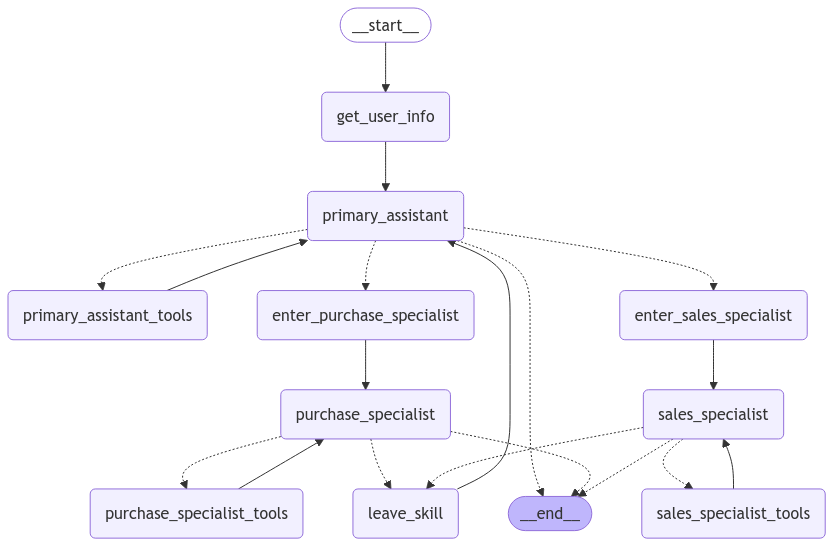

In [1016]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

## Let's run our service

In [1017]:
import shutil
import uuid

thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "thread_id": thread_id,
        "user_id": "user1",
    }
}

events = graph.stream(
    {"messages": ("user", "Please recommend items suitable for sporty activities.")}, config, stream_mode="values"
)

In [1018]:
for event in events:
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Please recommend items suitable for sporty activities.
================================ Human Message =================================

Please recommend items suitable for sporty activities.
================================== Ai Message ==================================
Tool Calls:
  check_validation (call_ezsUpd5idMyXUZATs41ORjIr)
 Call ID: call_ezsUpd5idMyXUZATs41ORjIr
  Args:
================================= Tool Message =================================
Name: check_validation

id='user1' name='John Doe' gender='Male' type='customer'
{'messages': [HumanMessage(content='Please recommend items suitable for sporty activities.', additional_kwargs={}, response_metadata={}, id='29848ae2-81fe-4675-8ae8-026f4106e274'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ezsUpd5idMyXUZATs41ORjIr', 'function': {'arguments': '{}', 'name': 'check_validation'}, 'type': 'function'}], 'refusal': N

In [1019]:
cursor.close()
conn.close()

With this, our shopping mall system is now complete.  
Although it is, in fact, almost incomplete.  
And I realized while making this tutorial that the example I created was not very suitable for applying the concept of multi-agent.

Still, I believe you were able to grasp the concept of how multi-agents are structured   
and how they operate by following this tutorial.

By using the concepts you have learned, I believe you will be able to create more suitable and impressive services!

Thank you for your hard work this time as well! Thank you.